In [ ]:
!unzip /content/FashionDataset.zip

In [ ]:
!pip install d2l
!pip install kornia

In [ ]:
import os
from d2l.torch import argmax, reduce_sum, astype
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision.datasets as dsets
from matplotlib import pyplot as plt
from skimage import transform, io
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset
import random
import math
from torchvision import models, utils
from PIL import Image
import datetime
#from kornia.losses import focal_loss
#import adabound

#configs
batch_size = 50
best_loss = 999
best_accu = 0

#models
dropout1 = 0.2
dropout2 = 0.5

#image transforms related
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

#Paths for Images

PATH = '/content/drive/MyDrive/Resnets/resnet50_22.pt'
BEST_LOSS_MODEL_PATH = '/content/drive/MyDrive/Resnets/resnet50_best_22.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOGS_PATH = '/content/drive/MyDrive/Resnets'
IMAGE_NAME = 'resnet_50_22.png'
BEST_ACCU_MODEL_PATH = '/content/drive/MyDrive/Resnets/resnet50_best_accu_22.pt'

# Data Loaders
class DataReader(Dataset):
    '''Fashion Dataset'''

    def __init__(self, labels_file, root_dir, image_file_ref, bbox_file, transform):

        self.data_labels = np.loadtxt(labels_file, dtype=np.uint8)
        self.root_dir = root_dir
        self.image_file_reference = pd.read_csv(image_file_ref, header=None)
        self.bboxes = np.loadtxt(bbox_file, usecols=(0,1,2,3))
        self.transform = transform

    def __len__(self):
        return len(self.data_labels)

    def __getitem__(self, idx):
        img_bbox = self.bboxes[idx]
        x1 = max(0, int(img_bbox[0]) - 10)
        y1 = max(0, int(img_bbox[1]) - 10)
        x2 = int(img_bbox[2]) + 10
        y2 = int(img_bbox[3]) + 10
        bbox_w = x2-x1
        bbox_h = y2-y1

        img_name = os.path.join(self.root_dir, self.image_file_reference.iloc[idx, 0] )
        image = Image.open(img_name).convert('RGB')
        image = image.crop(box=(x1,y1,x2,y2))
        image.thumbnail((pretrained_size,pretrained_size), Image.ANTIALIAS)
        # image = io.imread(img_name)
        labels = torch.from_numpy(self.data_labels[idx])
        #bbox = torch.from_numpy(self.bbox_file_ref[idx])
        transform_image = self.transform(image)
        sample = {'image': transform_image, 'labels': labels}
        return sample

# Data Transforms
data_transform = transforms.Compose([#transforms.ToPILImage(),
                                     transforms.RandomChoice(
                                         [transforms.Resize((pretrained_size,pretrained_size)),
                                         transforms.RandomResizedCrop((pretrained_size,pretrained_size))]
                                     ),
                                     transforms.RandomPerspective(),
                                     transforms.RandomGrayscale(p=0.2),
                                     
                                     #transforms.CenterCrop(pretrained_size),
                                     #transforms.RandomRotation(5),
                                     #transforms.Pad(padding=10, fill=0, padding_mode='constant'),
                                     #transforms.RandomCrop(pretrained_size),
                                     transforms.RandomChoice([
                                                              transforms.RandomHorizontalFlip(),
                                                              transforms.RandomVerticalFlip()]),
                                     #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=pretrained_means,
                                                        std=pretrained_stds)
                                     ])


test_data_transform = transforms.Compose([#transforms.ToPILImage(),
                                     transforms.Resize(pretrained_size),
                                     transforms.CenterCrop(pretrained_size),
                                     #transforms.RandomRotation(5),
                                     #transforms.RandomResizedCrop(pretrained_size),
                                     #transforms.RandomHorizontalFlip(),
                                     #transforms.RandomCrop(pretrained_size, padding=10),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=pretrained_means,
                                                        std=pretrained_stds)
                                     ])

train_dataset = DataReader(
    labels_file='/content/FashionDataset/split/train_attr.txt',
    root_dir='/content/FashionDataset',
    image_file_ref='/content/FashionDataset/split/train.txt',
    bbox_file = '/content/FashionDataset/split/train_bbox.txt',
    transform=data_transform)

test_dataset = DataReader(
    labels_file='/content/FashionDataset/split/val_attr.txt',
    root_dir='/content/FashionDataset',
    image_file_ref='/content/FashionDataset/split/val.txt',
    bbox_file = '/content/FashionDataset/split/val_bbox.txt',
    transform=test_data_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);


# Utilities
def show_one_image(tensor_image):
    plt.imshow(tensor_image.permute(1, 2, 0))

def picshow(tensors):
    grid_img = utils.make_grid(tensors, nrow=round(len(tensors)/2))
    plt.imshow(grid_img.permute(1, 2, 0))

def plot_graph_2_variables(var1, var2, x_label, y_label, legend, title=None, image_name = None):
    plt.plot(var1, '-o')
    plt.plot(var2, '-o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(legend)
    if title:
        plt.title(title)
    if image_name is None:
        #image_name = 'abc.png'
        image_name = datetime.datetime.now().strftime("%m_%d_%Y_%H%M%S.png")
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(os.path.join(LOGS_PATH,image_name), dpi=100)

# ResNet-50 with modified fully connected layer
class MyResnetModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.fc = self.resnet.fc
        self.in_features = self.resnet.fc.in_features
        self.feature_extractor = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        
        self.linear_label1 = nn.Linear(2048, out_features=7)
        self.linear_label2 = nn.Linear(2048, out_features=3)
        self.linear_label3 = nn.Linear(2048, out_features=3)
        self.linear_label4 = nn.Linear(2048, out_features=4)
        self.linear_label5 = nn.Linear(2048, out_features=6)
        self.linear_label6 = nn.Linear(2048, out_features=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout1)
        self.untrained_linear_label = nn.Linear(2048, 2048)

    def forward(self, input):
        out_features = self.feature_extractor(input)
        out_features = out_features.view(out_features.size(0), -1)
        out_features = self.relu(self.untrained_linear_label(out_features))
        out_features = self.dropout(out_features)
        
        out_pred_1 = self.linear_label1(out_features)
        out_pred_2 = self.linear_label2(out_features)
        out_pred_3 = self.linear_label3(out_features)
        out_pred_4 = self.linear_label4(out_features)
        out_pred_5 = self.linear_label5(out_features)
        out_pred_6 = self.linear_label6(out_features)
        return out_pred_1, out_pred_2, out_pred_3, out_pred_4, out_pred_5, out_pred_6

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = MyResnetModel()
print(model)
model.apply(init_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
print(torch.cuda.is_available())


def show_images(images, cols=1, titles=None):
    """Display a list of images in a single figure with matplotlib.

    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    cols (Default = 1): Number of columns in figure (number of rows is
                        set to np.ceil(n_images/float(cols))).

    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert ((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

def get_accuracy(pred_cat_1, pred_cat_2, pred_cat_3, pred_cat_4, pred_cat_5, pred_cat_6, target_label):
    pred_cat_1 = argmax(pred_cat_1, axis=1)
    pred_cat_2 = argmax(pred_cat_2, axis=1)
    pred_cat_3 = argmax(pred_cat_3, axis=1)
    pred_cat_4 = argmax(pred_cat_4, axis=1)
    pred_cat_5 = argmax(pred_cat_5, axis=1)
    pred_cat_6 = argmax(pred_cat_6, axis=1)

    pred_cat_1 = pred_cat_1.reshape([pred_cat_1.shape[0],1])
    pred_cat_2 = pred_cat_2.reshape([pred_cat_2.shape[0],1])
    pred_cat_3 = pred_cat_3.reshape([pred_cat_3.shape[0],1])
    pred_cat_4 = pred_cat_4.reshape([pred_cat_4.shape[0],1])
    pred_cat_5 = pred_cat_5.reshape([pred_cat_5.shape[0],1])
    pred_cat_6 = pred_cat_6.reshape([pred_cat_6.shape[0],1])

    pred = torch.cat((pred_cat_1, pred_cat_2, pred_cat_3, pred_cat_4, pred_cat_5, pred_cat_6), 1)

    comparison = astype(pred, target_label.dtype) == target_label
    return float(reduce_sum(astype(comparison, target_label.dtype)))


steps = 0

learning_rate = 0.05;
epochs = 40

# Training and Evaluation

criterion = nn.CrossEntropyLoss()
#riterion = focal_loss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=0.01) #momentum=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience= 3, factor=0.5, verbose=True )
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_loss_arr = []
eval_loss_arr = []

for epoch in range(epochs):
    model.train()
    train_loss, valid_loss = 0.0, 0.0
    steps = 0
    saved = False

    for tr_data in train_loader:
        inputs = tr_data['image']
        labels = tr_data['labels']
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        pc1, pc2, pc3, pc4, pc5, pc6 = model(inputs)

        # loss1 = focal_loss(pc1.to(device), (labels[:, 0].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
        # loss2 = focal_loss(pc2.to(device), (labels[:, 1].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
        # loss3 = focal_loss(pc3.to(device), (labels[:, 2].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
        # loss4 = focal_loss(pc4.to(device), (labels[:, 3].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
        # loss5 = focal_loss(pc5.to(device), (labels[:, 4].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
        # loss6 = focal_loss(pc6.to(device), (labels[:, 5].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
        loss1 = criterion(pc1.to(device), (labels[:, 0].type(torch.LongTensor)).to(device))
        loss2 = criterion(pc2.to(device), (labels[:, 1].type(torch.LongTensor)).to(device))
        loss3 = criterion(pc3.to(device), (labels[:, 2].type(torch.LongTensor)).to(device))
        loss4 = criterion(pc4.to(device), (labels[:, 3].type(torch.LongTensor)).to(device))
        loss5 = criterion(pc5.to(device), (labels[:, 4].type(torch.LongTensor)).to(device))
        loss6 = criterion(pc6.to(device), (labels[:, 5].type(torch.LongTensor)).to(device))
        sum_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
        sum_loss.backward()
        optimizer.step()
        train_loss += sum_loss.item()
        print('Iter : %s/%s,  Loss: %s' % (steps, len(train_loader), sum_loss.item()))
    tr_loss = train_loss / len(train_loader)
    train_loss_arr.append(tr_loss)
    model.eval()
    sum_accuracy = 0
    vl_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        val_steps = 0
        for tst_dt in test_loader:
            tst_loader_len = len(test_loader)
            inputs = tst_dt['image']
            labels = tst_dt['labels']
            inputs, labels = inputs.to(device), labels.to(device)
            val_steps += 1
            pc1, pc2, pc3, pc4, pc5, pc6 = model(inputs)
            # loss1 = focal_loss(pc1.to(device), (labels[:, 0].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
            # loss2 = focal_loss(pc2.to(device), (labels[:, 1].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
            # loss3 = focal_loss(pc3.to(device), (labels[:, 2].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
            # loss4 = focal_loss(pc4.to(device), (labels[:, 3].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
            # loss5 = focal_loss(pc5.to(device), (labels[:, 4].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
            # loss6 = focal_loss(pc6.to(device), (labels[:, 5].type(torch.LongTensor)).to(device),alpha=0.5, gamma=2.0, reduction='mean')
            loss1 = criterion(pc1.to(device), (labels[:, 0].type(torch.LongTensor)).to(device))
            loss2 = criterion(pc2.to(device), (labels[:, 1].type(torch.LongTensor)).to(device))
            loss3 = criterion(pc3.to(device), (labels[:, 2].type(torch.LongTensor)).to(device))
            loss4 = criterion(pc4.to(device), (labels[:, 3].type(torch.LongTensor)).to(device))
            loss5 = criterion(pc5.to(device), (labels[:, 4].type(torch.LongTensor)).to(device))
            loss6 = criterion(pc6.to(device), (labels[:, 5].type(torch.LongTensor)).to(device))
            sum_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
            valid_loss += sum_loss.item()

            accuracy_float = get_accuracy((pc1).to(device),
                                          (pc2).to(device),
                                          (pc3).to(device),
                                          (pc4).to(device),
                                          (pc5).to(device),
                                          (pc6).to(device), (labels).to(device))
            accuracy = accuracy_float / (batch_size * 6)
            total_accuracy += accuracy

            print(
                'Iter : %s/%s,  Accuracy: %s' % (val_steps, tst_loader_len, accuracy))

    curr_lr = optimizer.param_groups[0]['lr']

    vl_loss = valid_loss / tst_loader_len
    eval_loss_arr.append(vl_loss)
    val_accuracy = total_accuracy/tst_loader_len
    print('Epoch : %s, Training Loss: %s,  Validation Loss: %s, Validation Accuracy: %s, LR: %s , Time: %s' % (epoch + 1, tr_loss, vl_loss, val_accuracy, curr_lr, datetime.datetime.now().strftime("%m/%d/%Y %H:%M:%S")))
    #scheduler.step()
    scheduler.step(vl_loss)
    # Save best model
    if vl_loss < best_loss  :
        print('saving best loss model at time : %s ' % datetime.datetime.now().strftime("%m/%d/%Y %H:%M:%S"))
        best_loss = vl_loss
        saved = True
        torch.save(model.state_dict(), BEST_LOSS_MODEL_PATH)
    
    if val_accuracy > best_accu :
        best_accu = val_accuracy        
        saved = True
        print('saving best accuracy model at time : %s ' % datetime.datetime.now().strftime("%m/%d/%Y %H:%M:%S"))
        torch.save(model.state_dict(), BEST_ACCU_MODEL_PATH)
      
    if curr_lr <= 0.00000005:
      print('Terminating because lr has gone too low')
      break
        

torch.save(model.state_dict(), PATH)
plot_graph_2_variables(train_loss_arr,eval_loss_arr,'epoch','losses',['Train','Valid'], 'Train vs Valid Losses', IMAGE_NAME)



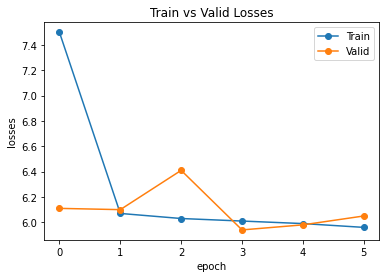

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
import os
from d2l.torch import argmax, reduce_sum, astype
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision.datasets as dsets
from matplotlib import pyplot as plt
from skimage import transform, io
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset
import random
import math
from torchvision import models, utils
from PIL import Image
import datetime
def plot_graph_2_variables(var1, var2, x_label, y_label, legend, title=None, image_name = None):
    plt.plot(var1, '-o')
    plt.plot(var2, '-o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(legend)
    if title:
        plt.title(title)
    if image_name is None:
        #image_name = 'abc.png'
        image_name = datetime.datetime.now().strftime("%m_%d_%Y_%H%M%S.png")
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(os.path.join(LOGS_PATH,image_name), dpi=100)
plot_graph_2_variables([7.50, 6.07,6.03,6.01,5.99,5.96 ],[6.11,6.10,6.41,5.94,5.98,6.05],'epoch','losses',['Train','Valid'], 'Train vs Valid Losses')

In [ ]:
import os
import time
BEST_ACCU_MODEL_PATH = '/content/drive/MyDrive/Resnets/resnet50_best_accu_13.pt'  
path = BEST_ACCU_MODEL_PATH
  
ti_m = os.path.getmtime(path)
  
m_ti = time.ctime(ti_m)
  
# Using the timestamp string to create a 
# time object/structure
t_obj = time.strptime(m_ti)
  
# Transforming the time object to a timestamp 
# of ISO 8601 format
T_stamp = time.strftime("%Y-%m-%d %H:%M:%S", t_obj)
  
print(f"The file located at the path {path} was last modified at {T_stamp}")

import datetime
print(datetime.datetime.now())

The file located at the path /content/drive/MyDrive/Resnets/resnet50_best_accu_13.pt was last modified at 2021-10-12 11:44:52
2021-10-12 12:25:29.557799


In [ ]:
LOAD_PATH =BEST_ACCU_MODEL_PATH


import sys
 
file_path = '/content/logs/prediction.txt'
sys.stdout = open(file_path, "w")

# Data Reader
class DataReaderForTest(Dataset):
    '''Fashion Dataset'''

    def __init__(self, root_dir, image_file_ref,bbox_file, transform):
        images = open(os.path.join(image_file_ref)).readlines()
        self.img_list = [x.strip() for x in images]
        self.root_dir = root_dir
        self.image_file_reference = pd.read_csv(image_file_ref, header=None)
        self.bboxes = np.loadtxt(bbox_file, usecols=(0,1,2,3))
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_bbox = self.bboxes[idx]
        x1 = max(0, int(img_bbox[0]) - 10)
        y1 = max(0, int(img_bbox[1]) - 10)
        x2 = int(img_bbox[2]) + 10
        y2 = int(img_bbox[3]) + 10
        bbox_w = x2-x1
        bbox_h = y2-y1
        img_name = self.root_dir+'/'+self.image_file_reference.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        image = image.crop(box=(x1,y1,x2,y2))
        image.thumbnail((pretrained_size,pretrained_size), Image.ANTIALIAS)

        transform_image = self.transform(image)
        sample = {'image': transform_image}
        return sample

# Data Loader
data_transform = test_data_transform

# data_transform = transforms.Compose([#transforms.ToPILImage(),
#                                      transforms.Resize(pretrained_size),
#                                      transforms.CenterCrop(pretrained_size),
#                                      #transforms.RandomRotation(5),
#                                      #transforms.RandomResizedCrop(pretrained_size),
#                                      #transforms.RandomHorizontalFlip(),
#                                      #transforms.RandomCrop(pretrained_size, padding=10),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize(mean=pretrained_means,
#                                                         std=pretrained_stds)
#                                      ])




test_dataset = DataReaderForTest(
    root_dir='/content/FashionDataset',
    image_file_ref='/content/FashionDataset/split/test.txt',
    bbox_file ='/content/FashionDataset/split/test_bbox.txt' ,
    transform=data_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False);
device = torch.device('cpu')
model = MyResnetModel()
model.load_state_dict(torch.load(LOAD_PATH, map_location='cpu'))
model.to(device)
model.eval()

def get_label_prediction(pred_cat_1, pred_cat_2, pred_cat_3, pred_cat_4, pred_cat_5, pred_cat_6):
    pred_cat_1 = argmax(pred_cat_1, axis=1)
    pred_cat_2 = argmax(pred_cat_2, axis=1)
    pred_cat_3 = argmax(pred_cat_3, axis=1)
    pred_cat_4 = argmax(pred_cat_4, axis=1)
    pred_cat_5 = argmax(pred_cat_5, axis=1)
    pred_cat_6 = argmax(pred_cat_6, axis=1)

    pred_cat_1 = pred_cat_1.reshape([pred_cat_1.shape[0],1])
    pred_cat_2 = pred_cat_2.reshape([pred_cat_2.shape[0],1])
    pred_cat_3 = pred_cat_3.reshape([pred_cat_3.shape[0],1])
    pred_cat_4 = pred_cat_4.reshape([pred_cat_4.shape[0],1])
    pred_cat_5 = pred_cat_5.reshape([pred_cat_5.shape[0],1])
    pred_cat_6 = pred_cat_6.reshape([pred_cat_6.shape[0],1])

    pred = torch.cat((pred_cat_1, pred_cat_2, pred_cat_3, pred_cat_4, pred_cat_5, pred_cat_6), 1)
    #print(pred)
    for x in pred:
      print('%s %s %s %s %s %s' % ( x[0].item(),x[1].item(),x[2].item(),x[3].item(),x[4].item(),x[5].item() )) 
      

with torch.no_grad():
    val_steps = 0
    for tst_dt in test_loader:
        tst_loader_len = len(test_loader)
        inputs = tst_dt['image']
        inputs = inputs.to(device)
        val_steps += 1
        pc1, pc2, pc3, pc4, pc5, pc6 = model(inputs)
        get_label_prediction((pc1).to(device),
                             (pc2).to(device),
                             (pc3).to(device),
                             (pc4).to(device),
                             (pc5).to(device),
                             (pc6).to(device))
        #break
       # print(
        #    'Iter : %s/%s ' % (val_steps, len(test_loader)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
